In [1]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Materials definition

fuel = openmc.Material(name='Fuel Kernel') #tpcu
fuel.add_nuclide('U235', 0.155)
fuel.add_nuclide('U238', 0.845)
fuel.add_element('C', 0.5)
fuel.add_element('O', 1.5)
fuel.set_density('g/cm3', 10.5)
fuel.temperature = 1200


buffer = openmc.Material(name='Buffer Layer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 1)
buffer.add_s_alpha_beta('c_Graphite')
buffer.temperature = 1200

IPyC = openmc.Material(name='Inner PyC Layer')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')
IPyC.temperature = 1200

SiC = openmc.Material(name = "SiC Layer")
SiC.add_element("Si", 1)
SiC.add_element("C", 1)
SiC.set_density("g/cm3", 3.2)
SiC.temperature = 1200

OPyC = openmc.Material(name='Outer PyC Layer')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite') 
OPyC.temperature = 1200

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.85)
graphite.add_s_alpha_beta('c_Graphite')
graphite.temperature = 800


helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.0051)
helium.temperature = 900


b4c = openmc.Material(name='B4C Poison')
b4c.add_element('B', 4.0, enrichment=19.8, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.52)
b4c.temperature = 1200






MA = openmc.Material()
MA.add_nuclide('Np237', 0.562, 'wo')
MA.add_nuclide('Am241', 0.264, 'wo')
MA.add_nuclide('Am243', 0.12, 'wo')
MA.add_nuclide('Cm243', 0.0003, 'wo')
MA.add_nuclide('Cm244', 0.0511, 'wo')
MA.add_nuclide('Cm245', 0.0026, 'wo')
MA.set_density('g/cm3', 15.43)
MA.temperature = 1200

# 5% minor actinide mix with kernel
MA_mix = openmc.Material.mix_materials([fuel,MA],[0.90, 0.1], 'wo')
MA_mix.temperature = 1200








# Instantiate a Materials collection and export to xml
materials_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium,
                  b4c,MA, MA_mix]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()







In [3]:
# Geometry definitions for TRISO particles

kernelsph = openmc.Sphere(r=0.02125)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
# triso_colors = {triso_cells[0]: (238,44,44), triso_cells[1]: (173,255,47), 
#                 triso_cells[2]: (32,178,170), triso_cells[3]: (75,0,130), 
#                 triso_cells[4]: (32,178,170)}
#triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)



In [4]:
# Generating TRISO particle lattice in cylindrical pin cell

cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.30)



triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]


vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)




lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])


#lattice_universe.plot(width=(1.8, 1.8), color_by='material', colors = {graphite: (97, 97, 97),fuel: (238, 59, 59)})



In [5]:
# Geometry definitions for Quadriso fuel MA_mix particles



kernelsph = openmc.Sphere(r=0.02125)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
quadriso_mats = [MA_mix, buffer, IPyC, SiC, OPyC]
quadriso_cells = []
for i in range(5):
  if (i == 0):
    quadriso_cells.append(openmc.Cell(fill=quadriso_mats[0], region=-layers[0]))
  else:
    quadriso_cells.append(openmc.Cell(fill=quadriso_mats[i], region=+layers[i-1] & -layers[i]))

quadriso_universe = openmc.Universe(cells=quadriso_cells)
# quadriso_colors = {quadriso_cells[0]: 'green', quadriso_cells[1]: 'blue', 
#                 quadriso_cells[2]: 'red', quadriso_cells[3]: 'cyan', 
#                 quadriso_cells[4]: 'red'}
# quadriso_universe.plot(width = (0.1, 0.1), colors = quadriso_colors)

In [6]:
# Generating quadRISO MA_mix particle lattice in cylindrical pin cell

cylsurf1 = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region4 = -cylsurf1 & -maxz & +minz
quadriso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=quadriso_outer_radius, region=lattice_region4, pf=0.3)



quadriso_particles = [openmc.model.TRISO(quadriso_outer_radius, fill=quadriso_universe, center=c) for c in spheres]


vol_quadriso = 4/3 * 3.14 * quadriso_outer_radius**3 * len(quadriso_particles)




lattice_cell4 = openmc.Cell(region=lattice_region4)
lower_left, upp_right = lattice_cell4.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
quadriso_latt = openmc.model.create_triso_lattice(quadriso_particles, lower_left, pitch, shape, graphite)
lattice_cell4.fill = quadriso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell4])


# lattice_universe.plot(width=(1.8, 1.8), color_by='material')

In [7]:
# Creating coolant cells
small_coolant_surf = openmc.ZCylinder(r=0.635)
big_coolant_surf = openmc.ZCylinder(r=0.794)

small_coolant_cell = openmc.Cell(region=-small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region=-big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region=+small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region=+big_coolant_surf & -maxz & +minz, fill=graphite)

scu = openmc.Universe(cells=[small_coolant_cell, outside_small_cell]) # scu means small coolant universe
bcu = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])     # bcu means big coolant universe


In [8]:
# poison_surf = openmc.ZCylinder(r=0.6375)
# poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
# outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

# pu = openmc.Universe(cells=[poison_cell, outside_poison_cell]) # pu means poison universe
# pu.plot(width=(1.8, 1.8), color_by='material',
#                           colors = {graphite: (97, 97, 97), fuel: (238, 59, 59), helium: (240, 255, 255),
#                                     b4c: (102, 205, 0)})

In [9]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region=outer_pin_region)

tpcu = openmc.Universe(cells=[lattice_cell, outer_pin_cell]) # tpcu means total pin cell universe

# tpcu.plot(width=(1.9, 1.9), color_by='material',
#                              colors = {graphite: (97, 97, 97), fuel: (238, 59, 59), helium: (240, 255, 255),
#                                        b4c: (102, 205, 0)})

In [10]:
outer_pin_region1 = +cylsurf1 & -maxz & +minz
outer_pin_cell1 = openmc.Cell(fill=graphite, region=outer_pin_region1)

mapcu = openmc.Universe(cells=[lattice_cell4, outer_pin_cell1]) # mapcu means total pin cell universe 2% ma_mix

# mapcu.plot(width=(1.9, 1.9), color_by='material')

In [11]:
outer_graphite_cell = openmc.Cell(fill=graphite)
ogu = openmc.Universe(cells=[outer_graphite_cell]) # ogu means outer graphite universe

# ogu.plot(width=(1.9, 1.9), color_by='material',
#                              colors = {graphite: (97, 97, 97), fuel: (238, 59, 59), helium: (240, 255, 255),
#                                        b4c: (102, 205, 0)})

In [12]:
# Construct geometry of the hexagonal fuel assembly
# ogu, tpcu, pu, scu, bcu
# outer_graphite_universe, total_pin_cell_universe, poison_universe, small_coolant_universe, big_coolant_universe

assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = ogu
assemblylat.pitch = (1.8796,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

outer_ring = ([ogu, tpcu, bcu] + [tpcu, tpcu, bcu]*2 + [tpcu])*2   +   ([ogu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu])*4

ring_1 = ([bcu, tpcu, tpcu]*3)*6

ring_2 = ([tpcu] + [bcu, tpcu, tpcu]*2 + [bcu])*6

ring_3 = ([tpcu, tpcu, bcu]*2 + [tpcu])*6

ring_4 = ([bcu, mapcu, mapcu]*2)*6 #mapcu

ring_5 = [tpcu, bcu, tpcu, tpcu, bcu]*6

ring_6 = [mapcu, mapcu, bcu, mapcu]*6 #mapcu

ring_7 = [bcu, tpcu, tpcu]*6

ring_8 = [mapcu, scu]*6 #mapcu

ring_9 = [ogu]*6 

inner_ring = [ogu]

assemblylat.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     ring_6,
                     ring_7,
                     ring_8,
                     ring_9,
                     inner_ring]
print(assemblylat)


HexLattice
	ID             =	142
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.8796,)
	Outer          =	141
	Universes      
                              141   139   138   139   139   138   139   139   138   139   141
                           139   138   139   139   138   139   139   138   139   139   138   139
                        138   139   139   138   139   139   138   139   139   138   139   139   138
                     139   139   138   139   139   138   139   139   138   139   139   138   139   139
                  139   138   139   139   138   140   140   138   140   140   138   139   139   138   139
               138   139   139   138   140   139   138   139   139   138   139   140   138   139   139   138
            139   139   138   139   140   138   140   140   138   140   140   138   140   139   138   139   139
         139   138   139   139   138   139   140   138   13

In [13]:


assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])



In [14]:
# assembly_universe.plot(width=(50, 50), pixels = (1000, 1000), color_by='cell')
#                        colors = {graphite: (97, 97, 97), lattice_cell: (238, 59, 59), helium: (240, 255, 255),
#                                  b4c: (102, 205, 0),
#                                 graphite1: (97, 97, 97), fuel1: 'yellow', helium1: (240, 255, 255),
#                                        b4c1: (102, 205, 0)})

# assembly_universe.plot(width=(50, 50), basis = 'xz', pixels = (1000, 1000), color_by='cell')

In [15]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()



In [16]:
# OpenMC simulation parameters

batches = 20
inactive = 5
particles = 5000

In [17]:
##############################################################################
#                   Exporting to OpenMC settings.xml file
##############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML

settings_file = openmc.Settings()
settings_file.temperature = {
		 'method'    :'interpolation',
		 'tolerance' : 300.0
}
# settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)


settings_file.export_to_xml()

In [18]:
# openmc.run()

In [19]:
import math
import openmc.deplete



fuel.volume = 4/3 * 3.1416 * 0.02125**3 * len(triso_particles) * 162

MA_mix.volume = 4/3 * 3.1416 * 0.02125**3 * len(quadriso_particles) * 48

chain = openmc.deplete.Chain.from_xml("/home/razu/Downloads/chain_casl_pwr.xml")


model = openmc.Model(geometry=geom, settings=settings_file)
operator = openmc.deplete.CoupledOperator(model, "/home/razu/Downloads/chain_casl_pwr.xml")



power = 113.1 * operator.heavy_metal
# power = (350000000/66)/10


In [20]:
print(power)

824490.946735122


In [21]:
# operator.heavy_metal

In [22]:

# power = 113.1 * operator.heavy_metal

In [23]:
# print(power)

In [24]:


time_steps = [30] * 20

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')




In [25]:


# integrator.integrate()



In [26]:
!ls *.h5

depletion_results.h5	  openmc_simulation_n17.h5  openmc_simulation_n6.h5
openmc_simulation_n0.h5   openmc_simulation_n18.h5  openmc_simulation_n7.h5
openmc_simulation_n10.h5  openmc_simulation_n19.h5  openmc_simulation_n8.h5
openmc_simulation_n11.h5  openmc_simulation_n1.h5   openmc_simulation_n9.h5
openmc_simulation_n12.h5  openmc_simulation_n20.h5  statepoint.15.h5
openmc_simulation_n13.h5  openmc_simulation_n2.h5   statepoint.20.h5
openmc_simulation_n14.h5  openmc_simulation_n3.h5   summary.h5
openmc_simulation_n15.h5  openmc_simulation_n4.h5
openmc_simulation_n16.h5  openmc_simulation_n5.h5


In [27]:
results = openmc.deplete.Results("./depletion_results.h5")



time, k = results.get_keff()



time /= (24 * 60 * 60)  # convert back to days from seconds




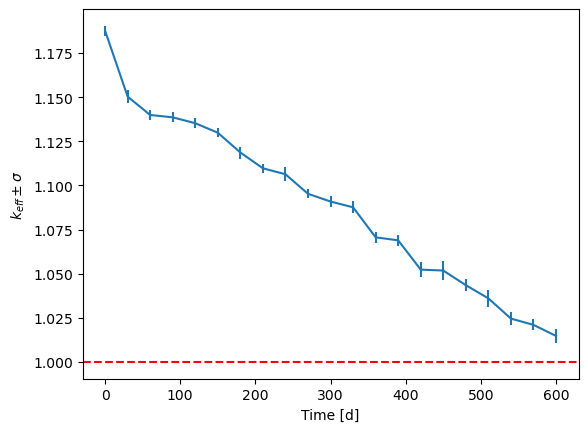

In [28]:

from matplotlib import pyplot



pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.axhline(y = 1, color = 'r', linestyle = '--')

In [29]:
k

array([[1.18761306, 0.00272775],
       [1.15030322, 0.00384254],
       [1.13987801, 0.00281418],
       [1.13855745, 0.00286012],
       [1.13522219, 0.0026852 ],
       [1.12983893, 0.00266019],
       [1.11862556, 0.00339893],
       [1.10968073, 0.00267937],
       [1.1063073 , 0.00394652],
       [1.09523426, 0.00245729],
       [1.09087   , 0.00307474],
       [1.08757919, 0.00333102],
       [1.07057707, 0.00297977],
       [1.06887874, 0.00324486],
       [1.05227509, 0.00434881],
       [1.05177434, 0.00523054],
       [1.0434627 , 0.00331356],
       [1.03600953, 0.00466787],
       [1.02454924, 0.00365225],
       [1.02100001, 0.00310931],
       [1.0147231 , 0.00388123]])

In [30]:
len(k)

21

In [31]:
time

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330., 360., 390., 420., 450., 480., 510., 540., 570., 600.])

In [32]:
k_ma = []
for i in range(0,len(k),1):
    k_ma.append(k[i][0])
print(k_ma)
len(k_ma)

[1.187613059863303, 1.1503032215465194, 1.139878012467239, 1.1385574459906833, 1.135222186345895, 1.1298389337991657, 1.1186255578297932, 1.1096807324681104, 1.1063072965356728, 1.0952342604039047, 1.0908699955292707, 1.08757918506618, 1.070577072440383, 1.0688787444043455, 1.052275094441581, 1.0517743376357533, 1.0434626958805375, 1.0360095305997366, 1.024549240850633, 1.0210000132057713, 1.0147230997620218]


21

In [33]:
print(operator.heavy_metal)
print(operator.heavy_metal/1000)

fuel_loading = operator.heavy_metal
print(fuel_loading)

7289.928795182334
7.289928795182335
7289.928795182334


In [34]:
burnup = (power * 10**(-6))*time/(fuel_loading/1000)
print(burnup)

[ 0.     3.393  6.786 10.179 13.572 16.965 20.358 23.751 27.144 30.537
 33.93  37.323 40.716 44.109 47.502 50.895 54.288 57.681 61.074 64.467
 67.86 ]


In [35]:
print(results.get_atoms("1", "U235"))

(array([       0.,  2592000.,  5184000.,  7776000., 10368000., 12960000.,
       15552000., 18144000., 20736000., 23328000., 25920000., 28512000.,
       31104000., 33696000., 36288000., 38880000., 41472000., 44064000.,
       46656000., 49248000., 51840000.]), array([2.18643020e+24, 2.11842776e+24, 2.05280999e+24, 1.98973473e+24,
       1.92897106e+24, 1.86999854e+24, 1.81285994e+24, 1.75738471e+24,
       1.70355857e+24, 1.65115052e+24, 1.60004956e+24, 1.55031336e+24,
       1.50191347e+24, 1.45455714e+24, 1.40847118e+24, 1.36366653e+24,
       1.32004968e+24, 1.27740378e+24, 1.23592460e+24, 1.19534304e+24,
       1.15594358e+24]))


In [36]:
k

array([[1.18761306, 0.00272775],
       [1.15030322, 0.00384254],
       [1.13987801, 0.00281418],
       [1.13855745, 0.00286012],
       [1.13522219, 0.0026852 ],
       [1.12983893, 0.00266019],
       [1.11862556, 0.00339893],
       [1.10968073, 0.00267937],
       [1.1063073 , 0.00394652],
       [1.09523426, 0.00245729],
       [1.09087   , 0.00307474],
       [1.08757919, 0.00333102],
       [1.07057707, 0.00297977],
       [1.06887874, 0.00324486],
       [1.05227509, 0.00434881],
       [1.05177434, 0.00523054],
       [1.0434627 , 0.00331356],
       [1.03600953, 0.00466787],
       [1.02454924, 0.00365225],
       [1.02100001, 0.00310931],
       [1.0147231 , 0.00388123]])

In [37]:
t1 = results.get_times(time_units = 'd') 
t1

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330., 360., 390., 420., 450., 480., 510., 540., 570., 600.])

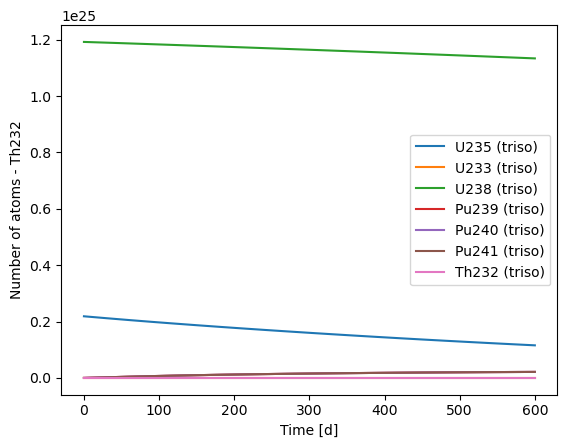

In [38]:

#fissile
_, u235 = results.get_atoms("1", "U235")
_, u233 = results.get_atoms("1", "U233")


_, pu239 = results.get_atoms("1", "Pu239")
_, pu241 = results.get_atoms("1", "Pu239")

#poisons
_, xe135 = results.get_atoms("1", "Xe135")
_, sm149 = results.get_atoms("1", "Sm149")



#fertile
_, th232 = results.get_atoms("1", "Th232")
_, u238 = results.get_atoms("1", "U238")
_, pu240 = results.get_atoms("1", "Pu239")

_, u235_10 = results.get_atoms("10", "U235")
_, xe135_10 = results.get_atoms("10", "Xe135")
_, pu239_10 = results.get_atoms("10", "Pu239")


#for deplete materials

#fissile
_, u235_10 = results.get_atoms("10", "U235")
_, u233_10 = results.get_atoms("10", "U233")


_, pu239_10 = results.get_atoms("10", "Pu239")
_, pu241_10= results.get_atoms("10", "Pu239")

#poisons
_, xe135_10 = results.get_atoms("10", "Xe135")
_, sm149_10 = results.get_atoms("10", "Sm149")



#fertile
_, th232_10 = results.get_atoms("10", "Th232")
_, u238_10 = results.get_atoms("10", "U238")
_, pu240_10 = results.get_atoms("10", "Pu239")

pyplot.plot(time, u235, label="U235 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");


pyplot.plot(time, u233, label="U233 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U233");

pyplot.plot(time, u238, label="U238 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U238");

pyplot.plot(time, pu239, label="Pu239 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.plot(time, pu240, label="Pu240 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu240");

pyplot.plot(time, pu241, label="Pu241 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu241");

pyplot.plot(time, th232, label="Th232 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Th232");
pyplot.legend()

In [39]:
print(u233)

[5.96942309e+05 6.03048136e+14 1.05619560e+15 2.06499198e+15
 2.85087386e+15 3.36295722e+15 4.63794277e+15 4.58037874e+15
 4.51872317e+15 5.63169721e+15 5.78448473e+15 5.71564911e+15
 6.90250161e+15 7.17775676e+15 7.28426231e+15 7.66328980e+15
 8.45829213e+15 8.43219531e+15 8.62453871e+15 8.81963447e+15
 9.76577120e+15]


In [40]:
print(u235)

[2.18643020e+24 2.11842776e+24 2.05280999e+24 1.98973473e+24
 1.92897106e+24 1.86999854e+24 1.81285994e+24 1.75738471e+24
 1.70355857e+24 1.65115052e+24 1.60004956e+24 1.55031336e+24
 1.50191347e+24 1.45455714e+24 1.40847118e+24 1.36366653e+24
 1.32004968e+24 1.27740378e+24 1.23592460e+24 1.19534304e+24
 1.15594358e+24]


In [41]:
print(u238)

[1.19195711e+25 1.18934568e+25 1.18664738e+25 1.18391941e+25
 1.18117481e+25 1.17840833e+25 1.17562530e+25 1.17278492e+25
 1.16995043e+25 1.16707193e+25 1.16417343e+25 1.16122899e+25
 1.15832448e+25 1.15530489e+25 1.15227663e+25 1.14917819e+25
 1.14609629e+25 1.14300033e+25 1.13983597e+25 1.13670407e+25
 1.13351561e+25]


In [42]:
print(pu239)

[5.96942309e+05 2.15720029e+22 4.37567065e+22 6.36278841e+22
 8.13247653e+22 9.71491347e+22 1.11275988e+23 1.24213851e+23
 1.35669412e+23 1.46012662e+23 1.55456863e+23 1.64064133e+23
 1.71370653e+23 1.78609039e+23 1.85152956e+23 1.91436932e+23
 1.96714776e+23 2.01418196e+23 2.06005785e+23 2.09687223e+23
 2.13147772e+23]


In [43]:
print(pu240)

[5.96942309e+05 2.15720029e+22 4.37567065e+22 6.36278841e+22
 8.13247653e+22 9.71491347e+22 1.11275988e+23 1.24213851e+23
 1.35669412e+23 1.46012662e+23 1.55456863e+23 1.64064133e+23
 1.71370653e+23 1.78609039e+23 1.85152956e+23 1.91436932e+23
 1.96714776e+23 2.01418196e+23 2.06005785e+23 2.09687223e+23
 2.13147772e+23]


In [44]:
print(pu241)

[5.96942309e+05 2.15720029e+22 4.37567065e+22 6.36278841e+22
 8.13247653e+22 9.71491347e+22 1.11275988e+23 1.24213851e+23
 1.35669412e+23 1.46012662e+23 1.55456863e+23 1.64064133e+23
 1.71370653e+23 1.78609039e+23 1.85152956e+23 1.91436932e+23
 1.96714776e+23 2.01418196e+23 2.06005785e+23 2.09687223e+23
 2.13147772e+23]


In [45]:
print(th232)

[5.96942309e+05 1.77370105e+13 6.89326110e+13 1.52230147e+14
 2.66192355e+14 4.09560332e+14 5.81216591e+14 7.80072340e+14
 1.00511549e+15 1.25531360e+15 1.52975733e+15 1.82757106e+15
 2.14778209e+15 2.48942900e+15 2.85174290e+15 3.23394422e+15
 3.63517142e+15 4.05454944e+15 4.49133819e+15 4.94494563e+15
 5.41441088e+15]


In [46]:
print(xe135)

[5.96942309e+05 2.48493797e+19 2.55453080e+19 2.56105405e+19
 2.56866092e+19 2.58149450e+19 2.58354841e+19 2.59257013e+19
 2.58830569e+19 2.58953045e+19 2.57012054e+19 2.58010254e+19
 2.55624944e+19 2.56090269e+19 2.54422297e+19 2.55270150e+19
 2.53961466e+19 2.51711913e+19 2.51245774e+19 2.48762389e+19
 2.48580672e+19]


In [47]:
print(sm149)

[5.96942309e+05 1.83645425e+20 2.09747318e+20 2.17719959e+20
 2.25623362e+20 2.33091171e+20 2.39607968e+20 2.46371093e+20
 2.51467445e+20 2.56118673e+20 2.58455348e+20 2.64524383e+20
 2.65248538e+20 2.69633116e+20 2.71286931e+20 2.77679258e+20
 2.78514271e+20 2.77756093e+20 2.80638274e+20 2.80113381e+20
 2.81863866e+20]


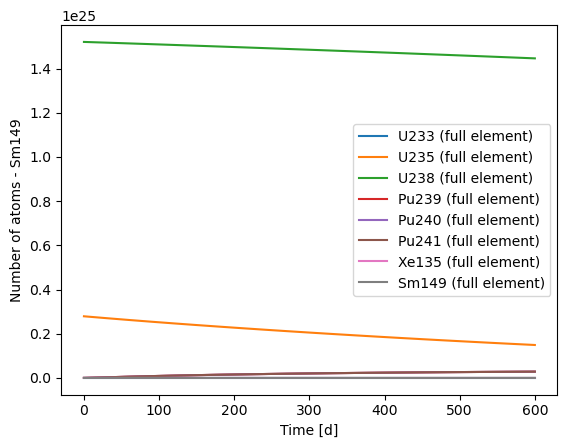

In [48]:
u235_all = u235 + u235_10
u233_all = u233 + u233_10
pu239_all = pu239 + pu239_10
pu241_all = pu241 + pu241_10

u238_all = u238 + u238_10
pu240_all = pu240 + pu240_10

xe135_all = xe135 + xe135_10
sm149_all = sm149 + sm149_10

pyplot.plot(time, u233_all, label="U233 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U233");


pyplot.plot(time, u235_all, label="U235 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

pyplot.plot(time, u238_all, label="U238 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U238");

pyplot.plot(time, pu239_all, label="Pu239 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.plot(time, pu240_all, label="Pu240 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu240");

pyplot.plot(time, pu241_all, label="Pu241 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu241");

pyplot.plot(time, xe135_all, label="Xe135 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");

pyplot.plot(time, sm149_all, label="Sm149 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Sm149");

pyplot.legend()


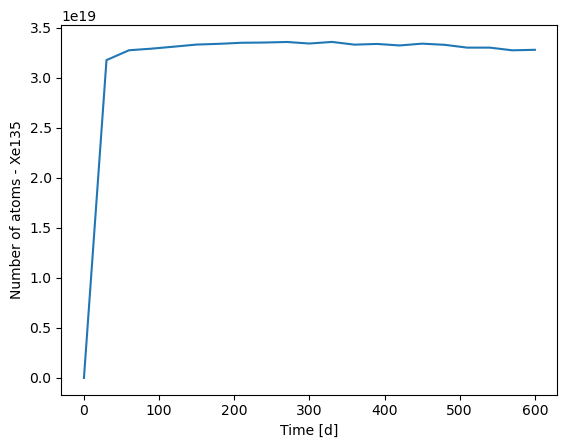

In [49]:
pyplot.plot(time, xe135_all, label="Xe135 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");

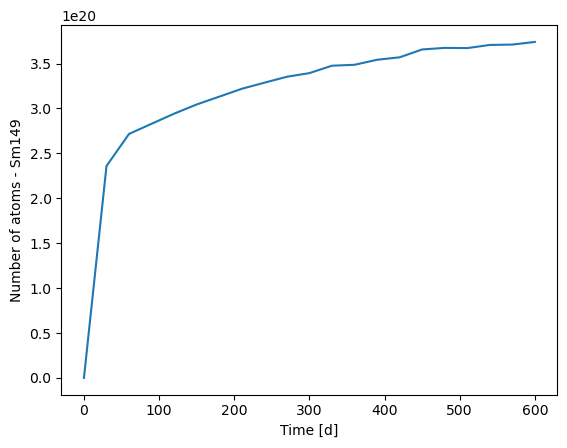

In [50]:
pyplot.plot(time, sm149_all, label="Sm149 (full element)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Sm149");

In [51]:
print(u235_all)

[2.78872192e+24 2.70365258e+24 2.62161065e+24 2.54257701e+24
 2.46624060e+24 2.39226081e+24 2.32046167e+24 2.25062641e+24
 2.18268938e+24 2.11660879e+24 2.05215573e+24 1.98938484e+24
 1.92820610e+24 1.86845582e+24 1.81019195e+24 1.75336970e+24
 1.69810009e+24 1.64410848e+24 1.59146940e+24 1.54010094e+24
 1.49010881e+24]


In [52]:
print(u233_all)

[7.73814104e+05 2.85517498e+15 8.08910086e+15 1.48290108e+16
 2.14143551e+16 2.76093851e+16 3.49097478e+16 3.99655236e+16
 4.46785705e+16 5.04650300e+16 5.49590760e+16 5.87605230e+16
 6.41585558e+16 6.77067585e+16 7.08679082e+16 7.40752018e+16
 7.76809406e+16 7.99450325e+16 8.23052991e+16 8.43744813e+16
 8.72876602e+16]


In [53]:
print(pu239_all)

[7.73814104e+05 2.74748856e+22 5.60141914e+22 8.16623038e+22
 1.04807628e+23 1.25426153e+23 1.43872242e+23 1.60924281e+23
 1.76160008e+23 1.90228252e+23 2.02999744e+23 2.14639454e+23
 2.24804877e+23 2.34683910e+23 2.43661770e+23 2.52356514e+23
 2.59843366e+23 2.66509669e+23 2.72972447e+23 2.78669273e+23
 2.83986508e+23]


In [54]:
print(pu241_all)

[7.73814104e+05 2.74748856e+22 5.60141914e+22 8.16623038e+22
 1.04807628e+23 1.25426153e+23 1.43872242e+23 1.60924281e+23
 1.76160008e+23 1.90228252e+23 2.02999744e+23 2.14639454e+23
 2.24804877e+23 2.34683910e+23 2.43661770e+23 2.52356514e+23
 2.59843366e+23 2.66509669e+23 2.72972447e+23 2.78669273e+23
 2.83986508e+23]


In [55]:
print(u238_all)

[1.52030324e+25 1.51698661e+25 1.51354514e+25 1.51007441e+25
 1.50655964e+25 1.50304304e+25 1.49950951e+25 1.49590296e+25
 1.49229649e+25 1.48861195e+25 1.48491769e+25 1.48117484e+25
 1.47746060e+25 1.47363530e+25 1.46979352e+25 1.46585359e+25
 1.46192638e+25 1.45799829e+25 1.45398186e+25 1.44997051e+25
 1.44589009e+25]


In [56]:
print(pu240_all)

[7.73814104e+05 2.74748856e+22 5.60141914e+22 8.16623038e+22
 1.04807628e+23 1.25426153e+23 1.43872242e+23 1.60924281e+23
 1.76160008e+23 1.90228252e+23 2.02999744e+23 2.14639454e+23
 2.24804877e+23 2.34683910e+23 2.43661770e+23 2.52356514e+23
 2.59843366e+23 2.66509669e+23 2.72972447e+23 2.78669273e+23
 2.83986508e+23]


In [57]:
print(xe135_all)

[7.73814104e+05 3.17465199e+19 3.27326670e+19 3.28925551e+19
 3.30928280e+19 3.33011389e+19 3.33753263e+19 3.34812977e+19
 3.35030760e+19 3.35591867e+19 3.34043515e+19 3.35647413e+19
 3.32929926e+19 3.33628536e+19 3.32122307e+19 3.33918560e+19
 3.32756885e+19 3.29946127e+19 3.29943377e+19 3.27273106e+19
 3.27767173e+19]


In [58]:
print(sm149_all)

[7.73814104e+05 2.35937498e+20 2.71674136e+20 2.82954582e+20
 2.94222093e+20 3.04466313e+20 3.13146413e+20 3.21917496e+20
 3.28672306e+20 3.35329454e+20 3.39369152e+20 3.47624515e+20
 3.48633786e+20 3.54219404e+20 3.56947516e+20 3.65707302e+20
 3.67464113e+20 3.67218504e+20 3.70739312e+20 3.71157329e+20
 3.74102127e+20]


In [59]:
print(u233_all)

print(u235_all)

print(u238_all)

print(pu239_all)

print(pu240_all)

print(pu241_all)

print(xe135_all)

print(sm149_all)

[7.73814104e+05 2.85517498e+15 8.08910086e+15 1.48290108e+16
 2.14143551e+16 2.76093851e+16 3.49097478e+16 3.99655236e+16
 4.46785705e+16 5.04650300e+16 5.49590760e+16 5.87605230e+16
 6.41585558e+16 6.77067585e+16 7.08679082e+16 7.40752018e+16
 7.76809406e+16 7.99450325e+16 8.23052991e+16 8.43744813e+16
 8.72876602e+16]
[2.78872192e+24 2.70365258e+24 2.62161065e+24 2.54257701e+24
 2.46624060e+24 2.39226081e+24 2.32046167e+24 2.25062641e+24
 2.18268938e+24 2.11660879e+24 2.05215573e+24 1.98938484e+24
 1.92820610e+24 1.86845582e+24 1.81019195e+24 1.75336970e+24
 1.69810009e+24 1.64410848e+24 1.59146940e+24 1.54010094e+24
 1.49010881e+24]
[1.52030324e+25 1.51698661e+25 1.51354514e+25 1.51007441e+25
 1.50655964e+25 1.50304304e+25 1.49950951e+25 1.49590296e+25
 1.49229649e+25 1.48861195e+25 1.48491769e+25 1.48117484e+25
 1.47746060e+25 1.47363530e+25 1.46979352e+25 1.46585359e+25
 1.46192638e+25 1.45799829e+25 1.45398186e+25 1.44997051e+25
 1.44589009e+25]
[7.73814104e+05 2.74748856e+22 5.6

In [60]:
_, u235_fission = results.get_reaction_rate("1", "U235", "fission")
_, u235_fission_10 = results.get_reaction_rate("10", "U235", "fission")

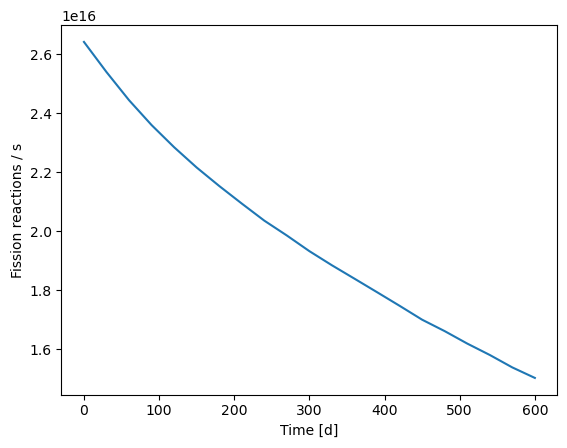

In [61]:
pyplot.plot(time, u235_fission+u235_fission_10)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

In [62]:
overall_fission_reaction_rate= u235_fission+u235_fission_10
print(overall_fission_reaction_rate)

[2.64216960e+16 2.53995765e+16 2.44450052e+16 2.36011871e+16
 2.28495846e+16 2.21613548e+16 2.15349234e+16 2.09390171e+16
 2.03590431e+16 1.98553056e+16 1.93238891e+16 1.88445543e+16
 1.83902072e+16 1.79324265e+16 1.74707362e+16 1.69989720e+16
 1.66116220e+16 1.61897842e+16 1.58028051e+16 1.53803767e+16
 1.50241019e+16]


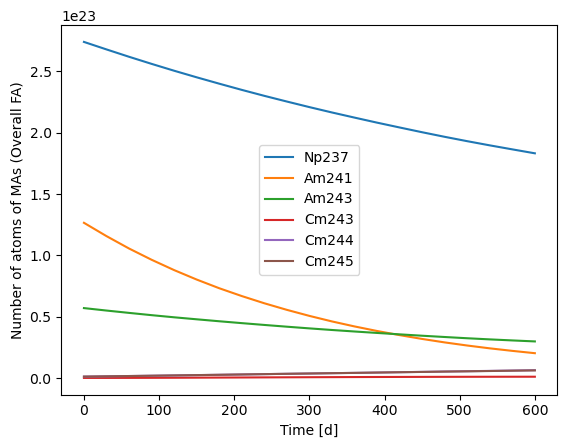

In [63]:

_, np237 = results.get_atoms("1","Np237")
_, am241 = results.get_atoms("1","Am241")
_, am243 = results.get_atoms("1", "Am243")
_, cm243 = results.get_atoms("1","Cm243")
_, cm244 = results.get_atoms("1","Cm244")
_, cm245 = results.get_atoms("1", "Cm245")

_, np237_10 = results.get_atoms("10","Np237")
_, am241_10 = results.get_atoms("10","Am241")
_, am243_10 = results.get_atoms("10", "Am243")
_, cm243_10 = results.get_atoms("10","Cm243")
_, cm244_10 = results.get_atoms("10","Cm244")
_, cm245_10 = results.get_atoms("10", "Cm245")


pyplot.plot(time, np237+np237_10, label="Np237", )

pyplot.plot(time, am241+am241_10, label="Am241")

pyplot.plot(time, am243+am243_10, label="Am243")

pyplot.plot(time, cm243+cm243_10, label="Cm243")

pyplot.plot(time, cm244+cm245_10, label="Cm244")

pyplot.plot(time, cm245+cm245_10, label="Cm245")


pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms of MAs (Overall FA)");
pyplot.legend()

In [64]:
print(np237)

[5.96942309e+05 2.99544753e+19 1.45182895e+20 3.49308132e+20
 6.32584722e+20 9.91183217e+20 1.42312525e+21 1.93131028e+21
 2.50673931e+21 3.13418181e+21 3.80691784e+21 4.54798277e+21
 5.33609969e+21 6.18283978e+21 7.07771091e+21 8.01012539e+21
 8.96357323e+21 9.95613515e+21 1.10039324e+22 1.20698059e+22
 1.31441254e+22]


In [65]:
print(am241)

[5.96942309e+05 2.85759056e+16 4.55991540e+17 2.17641871e+18
 6.39208112e+18 1.43093334e+19 2.70594863e+19 4.55973602e+19
 7.06783729e+19 1.02707339e+20 1.41982344e+20 1.88593962e+20
 2.42605981e+20 3.03796708e+20 3.72000772e+20 4.46710604e+20
 5.27515699e+20 6.13638243e+20 7.04324674e+20 7.99210444e+20
 8.96516736e+20]


In [66]:
print(am243)

[5.96942309e+05 8.20980401e+14 2.89076390e+16 2.12542207e+17
 8.38661744e+17 2.45453396e+18 5.78780125e+18 1.18221622e+19
 2.17068079e+19 3.63256929e+19 5.76316382e+19 8.73182226e+19
 1.25768606e+20 1.75899965e+20 2.38170802e+20 3.15700721e+20
 4.07903413e+20 5.19370340e+20 6.48924115e+20 7.95479079e+20
 9.66214104e+20]


In [67]:
print(cm243)

[5.96942309e+05 2.10679509e+11 1.57788263e+13 1.77772494e+14
 9.41257759e+14 3.32875495e+15 9.21832393e+15 2.15376860e+16
 4.42562454e+16 8.25057570e+16 1.41984340e+17 2.32863049e+17
 3.58129953e+17 5.30817279e+17 7.63449765e+17 1.06066896e+18
 1.43513275e+18 1.90008903e+18 2.45596150e+18 3.11592119e+18
 3.90277362e+18]


In [68]:
print(cm244)

[5.96942309e+05 5.51467900e+12 4.13999597e+14 4.71437910e+15
 2.52094493e+16 9.27923401e+16 2.68879460e+17 6.53153400e+17
 1.39261965e+18 2.66834728e+18 4.76617514e+18 8.01594631e+18
 1.28343440e+19 1.97621988e+19 2.93115361e+19 4.23548207e+19
 5.92618057e+19 8.12258566e+19 1.09010283e+20 1.42598036e+20
 1.84856581e+20]


In [69]:
print(cm245)

[5.96942309e+05 1.04346420e+10 1.59007022e+12 2.75789087e+13
 1.96903880e+14 9.17056236e+14 3.21922726e+15 9.08344514e+15
 2.24555840e+16 4.92173567e+16 9.74932805e+16 1.84488893e+17
 3.22450063e+17 5.40078232e+17 8.66078114e+17 1.34056713e+18
 2.02200758e+18 2.93532696e+18 4.23303375e+18 5.92353600e+18
 8.05684332e+18]


In [70]:
Overall_np237= np237+np237_10
Overall_am241= am241+am241_10
Overall_am243= am243+am243_10
Overall_cm243= cm243+cm243_10
Overall_cm244= cm244+cm245_10
Overall_cm245= cm245+cm245_10

In [71]:
print(Overall_np237)

[2.73905679e+23 2.67792636e+23 2.61800033e+23 2.56023848e+23
 2.50430622e+23 2.45073307e+23 2.39884545e+23 2.34832132e+23
 2.29976678e+23 2.25333048e+23 2.20791495e+23 2.16425950e+23
 2.12244932e+23 2.08136174e+23 2.04199851e+23 2.00318862e+23
 1.96586028e+23 1.93029780e+23 1.89628273e+23 1.86364980e+23
 1.83146110e+23]


In [72]:
print(Overall_am241)

[1.26527760e+23 1.15675810e+23 1.05584863e+23 9.64168446e+22
 8.79941938e+22 8.02957237e+22 7.32183853e+22 6.68444619e+22
 6.09669775e+22 5.56075872e+22 5.06846410e+22 4.61735031e+22
 4.21005359e+22 3.83851635e+22 3.50132114e+22 3.19036134e+22
 2.90770451e+22 2.65441177e+22 2.42442362e+22 2.21838762e+22
 2.02908976e+22]


In [73]:
print(Overall_am243)

[5.70383058e+22 5.50351547e+22 5.31295752e+22 5.12790740e+22
 4.95382135e+22 4.79056339e+22 4.63108343e+22 4.47853031e+22
 4.33081888e+22 4.18816839e+22 4.05031541e+22 3.91978049e+22
 3.79685453e+22 3.67912365e+22 3.56438514e+22 3.45239914e+22
 3.34818683e+22 3.24643472e+22 3.15421110e+22 3.06925562e+22
 2.98808677e+22]


In [74]:
print(Overall_cm243)

[1.42595760e+20 1.47495513e+20 1.76199309e+20 2.23488665e+20
 2.85015145e+20 3.54287808e+20 4.26008986e+20 5.01769710e+20
 5.78822740e+20 6.48588224e+20 7.16941620e+20 7.82885626e+20
 8.44543583e+20 8.99181619e+20 9.46637429e+20 9.91448589e+20
 1.03007558e+21 1.06334069e+21 1.08911370e+21 1.10793226e+21
 1.11975934e+21]


In [75]:
print(Overall_cm244)

[1.22572352e+21 1.45093523e+21 1.68226017e+21 1.93081414e+21
 2.18078782e+21 2.43362354e+21 2.69333665e+21 2.96157209e+21
 3.23396786e+21 3.50194363e+21 3.74936287e+21 4.00568241e+21
 4.25439819e+21 4.52880398e+21 4.80171674e+21 5.06704557e+21
 5.36175395e+21 5.60004835e+21 5.87525090e+21 6.16536606e+21
 6.44512898e+21]


In [76]:
print(Overall_cm245)

[1.22572352e+21 1.45093523e+21 1.68225976e+21 1.93080945e+21
 2.18076281e+21 2.43353167e+21 2.69307099e+21 2.96092802e+21
 3.23259770e+21 3.49932450e+21 3.74469418e+21 3.99785095e+21
 4.24188630e+21 4.50958186e+21 4.77327128e+21 5.02603131e+21
 5.30451415e+21 5.52175782e+21 5.77047365e+21 6.02869156e+21
 6.26832924e+21]


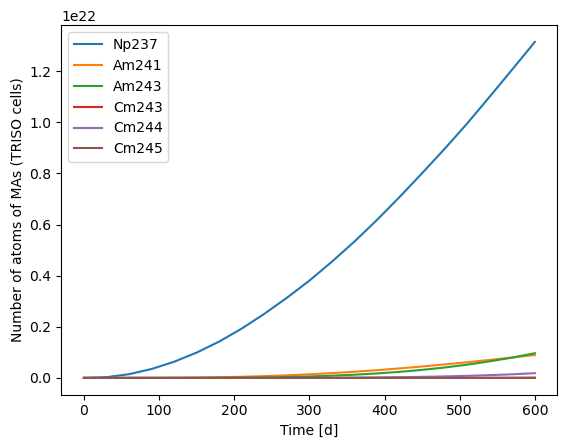

In [77]:
pyplot.plot(time, np237, label="Np237", )

pyplot.plot(time, am241, label="Am241")

pyplot.plot(time, am243, label="Am243")

pyplot.plot(time, cm243, label="Cm243")

pyplot.plot(time, cm244, label="Cm244")

pyplot.plot(time, cm245, label="Cm245")


pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms of MAs (TRISO cells)");
pyplot.legend()

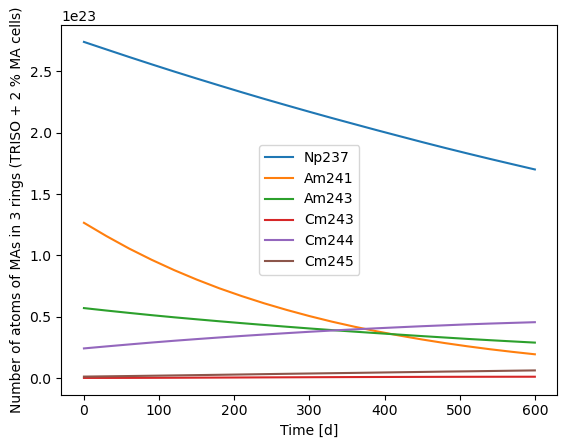

In [78]:

pyplot.plot(time, np237_10, label="Np237", )

pyplot.plot(time, am241_10, label="Am241")

pyplot.plot(time, am243_10, label="Am243")

pyplot.plot(time, cm243_10, label="Cm243")

pyplot.plot(time, cm244_10, label="Cm244")

pyplot.plot(time, cm245_10, label="Cm245")


pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms of MAs in 3 rings (TRISO + 2 % MA cells)");
pyplot.legend()

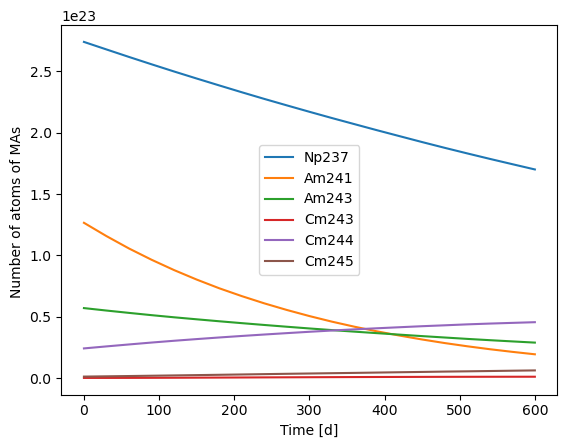

In [79]:
# Minor actinide (MA) composition

# MA = openmc.Material(name = 'Minor Actinides')
# MA.add_nuclide('Np237', 0.562, 'wo')
# MA.add_nuclide('Am241', 0.264, 'wo')
# MA.add_nuclide('Am243', 0.12, 'wo')
# MA.add_nuclide('Cm243', 0.0003, 'wo')
# MA.add_nuclide('Cm244', 0.0511, 'wo')
# MA.add_nuclide('Cm245', 0.0026, 'wo')
# MA.set_density('g/cm3', 15.43)

_, np237 = results.get_atoms("10","Np237")
_, am241 = results.get_atoms("10","Am241")
_, am243 = results.get_atoms("10", "Am243")
_, cm243 = results.get_atoms("10","Cm243")
_, cm244 = results.get_atoms("10","Cm244")
_, cm245 = results.get_atoms("10", "Cm245")


pyplot.plot(time, np237, label="Np237", )

pyplot.plot(time, am241, label="Am241")

pyplot.plot(time, am243, label="Am243")


pyplot.plot(time, cm243, label="Cm243")

pyplot.plot(time, cm244, label="Cm244")


pyplot.plot(time, cm245, label="Cm245")


pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms of MAs ");
pyplot.legend()


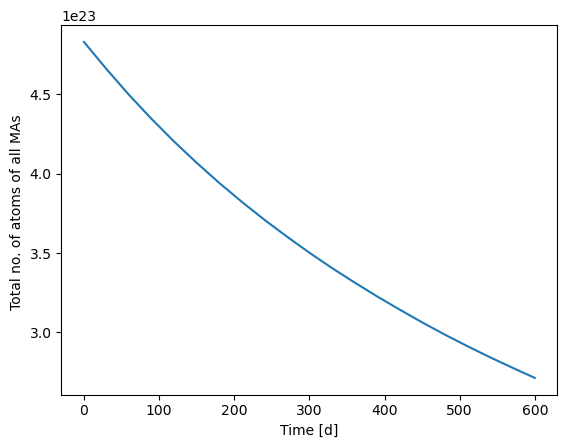

In [80]:
pyplot.plot(time, np237+am241+am243+cm243+cm244+cm245)


pyplot.xlabel("Time [d]")
pyplot.ylabel("Total no. of atoms of all MAs ");

In [81]:
print(np237)

[2.73905679e+23 2.67762681e+23 2.61654850e+23 2.55674540e+23
 2.49798038e+23 2.44082124e+23 2.38461419e+23 2.32900822e+23
 2.27469939e+23 2.22198867e+23 2.16984577e+23 2.11877968e+23
 2.06908833e+23 2.01953334e+23 1.97122140e+23 1.92308737e+23
 1.87622455e+23 1.83073644e+23 1.78624340e+23 1.74295174e+23
 1.70001984e+23]


In [82]:
print(am241)

[1.26527760e+23 1.15675782e+23 1.05584407e+23 9.64146682e+22
 8.79878018e+22 8.02814144e+22 7.31913258e+22 6.67988645e+22
 6.08962991e+22 5.55048798e+22 5.05426586e+22 4.59849091e+22
 4.18579299e+22 3.80813668e+22 3.46412106e+22 3.14569028e+22
 2.85495294e+22 2.59304795e+22 2.35399115e+22 2.13846658e+22
 1.93943808e+22]


In [83]:
print(am243)

[5.70383058e+22 5.50351539e+22 5.31295463e+22 5.12788615e+22
 4.95373749e+22 4.79031794e+22 4.63050465e+22 4.47734810e+22
 4.32864820e+22 4.18453582e+22 4.04455224e+22 3.91104867e+22
 3.78427767e+22 3.66153366e+22 3.54056806e+22 3.42082907e+22
 3.30739649e+22 3.19449769e+22 3.08931869e+22 2.98970772e+22
 2.89146536e+22]


In [84]:
print(cm243)

[1.42595760e+20 1.47495513e+20 1.76199293e+20 2.23488487e+20
 2.85014204e+20 3.54284479e+20 4.25999768e+20 5.01748172e+20
 5.78778484e+20 6.48505718e+20 7.16799636e+20 7.82652763e+20
 8.44185453e+20 8.98650801e+20 9.45873979e+20 9.90387920e+20
 1.02864044e+21 1.06144060e+21 1.08665774e+21 1.10481633e+21
 1.11585657e+21]


In [85]:
print(cm244)

[2.41891568e+22 2.58276253e+22 2.74158520e+22 2.89631399e+22
 3.04207640e+22 3.17815709e+22 3.30926334e+22 3.43295607e+22
 3.55077396e+22 3.66399652e+22 3.77383599e+22 3.87686644e+22
 3.97214362e+22 4.05967606e+22 4.14462306e+22 4.22813680e+22
 4.30135607e+22 4.37810560e+22 4.44253258e+22 4.49921266e+22
 4.55521720e+22]


In [86]:
print(cm245)

[1.22572352e+21 1.45093523e+21 1.68225975e+21 1.93080942e+21
 2.18076261e+21 2.43353075e+21 2.69306777e+21 2.96091894e+21
 3.23257524e+21 3.49927528e+21 3.74459669e+21 3.99766646e+21
 4.24156385e+21 4.50904178e+21 4.77240520e+21 5.02469075e+21
 5.30249215e+21 5.51882249e+21 5.76624061e+21 6.02276802e+21
 6.26027240e+21]


In [87]:
print('Initial MA amount in the fuel element: \n')
print('Np-237',(np237[0])*237/6.023e23,'g')
print('Am-241',(am241[0])*241/6.023e23,'g')
print('Am-243',(am243[0])*243/6.023e23,'g')
print('Cm-243',(cm243[0])*243/6.023e23,'g')
print('Cm-244',(cm244[0])*244/6.023e23,'g')
print('Cm-245',(cm245[0])*245/6.023e23,'g')

print('\nFinal MA amount in the fuel element: \n')
print('Np-237',(np237[-1])*237/6.023e23,'g')
print('Am-241',(am241[-1])*241/6.023e23,'g')
print('Am-243',(am243[-1])*243/6.023e23,'g')
print('Cm-243',(cm243[-1])*243/6.023e23,'g')
print('Cm-244',(cm244[-1])*244/6.023e23,'g')
print('Cm-245',(cm245[-1])*245/6.023e23,'g')

Initial MA amount in the fuel element: 

Np-237 107.77958797681809 g
Am-241 50.627910130689514 g
Am-243 23.01230004484302 g
Cm-243 0.05753074835111709 g
Cm-244 9.799359541100937 g
Cm-245 0.49859249774401604 g

Final MA amount in the fuel element: 

Np-237 66.89435546102443 g
Am-241 7.760328370813993 g
Am-243 11.66571612977838 g
Cm-243 0.45019615810575964 g
Cm-244 18.453810358857417 g
Cm-245 2.546516251025209 g


In [88]:
print('Change in MA amount in the fuel element: \n')
print('Np-237',(np237[-1]-np237[0])*237/6.023e23,'g')
print('Am-241',(am241[-1]-am241[0])*241/6.023e23,'g')
print('Am-243',(am243[-1]-am243[0])*243/6.023e23,'g')
print('Cm-243',(cm243[-1]-cm243[0])*243/6.023e23,'g')
print('Cm-244',(cm244[-1]-cm244[0])*244/6.023e23,'g')
print('Cm-245',(cm245[-1]-cm245[0])*245/6.023e23,'g')

print('\nTransmutation rates: \n')
print('Np-237',(np237[0]-np237[-1])*365*100/(np237[0]*time[-1]),'% per year')
print('Am-241',(am241[0]-am241[-1])*365*100/(am241[0]*time[-1]),'% per year')
print('Am-243',(am243[0]-am243[-1])*365*100/(am243[0]*time[-1]),'% per year')
print('Cm-243',(cm243[0]-cm243[-1])*365*100/(cm243[0]*time[-1]),'% per year')
print('Cm-244',(cm244[0]-cm244[-1])*365*100/(cm244[0]*time[-1]),'% per year')
print('Cm-245',(cm245[0]-cm245[-1])*365*100/(cm245[0]*time[-1]),'% per year')

Change in MA amount in the fuel element: 

Np-237 -40.88523251579365 g
Am-241 -42.86758175987553 g
Am-243 -11.346583915064642 g
Cm-243 0.3926654097546425 g
Cm-244 8.654450817756478 g
Cm-245 2.0479237532811934 g

Transmutation rates: 

Np-237 23.076586436562305 % per year
Am-241 51.50870110302361 % per year
Am-243 29.99485145573046 % per year
Cm-243 -415.2065885583124 % per year
Cm-244 -53.72586741055225 % per year
Cm-245 -249.86743460501884 % per year
